# Detect malicious users in WhatsApp public groups
* Malicious users repeatedly and intentionaly spread misinformation (bots, cyborgs, trolls)
* Low credibility / gullible users
* Superspreaders / influencers/ persuaders
* Source of fake news (SOFN)

In [106]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
from utils import preprocess
from utils import get_user_features, getTopUsers
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


%matplotlib inline
sns.set(style="darkgrid")

# Load data

In [146]:
# conversations
df = pd.read_csv('data/2018/high quality labels/fakeWhatsApp.BR_2018.csv')
df.head(3)

C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,shares,text,misinformation,preprocessed_text,ambiguity,preprocessed_text_stemmed
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,-1.0,< arqu mid ocult >
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0,bolsonaro estar preparado pra responder assim ...,0.0,bolsonar est prepar pra respond assim . . .
2,-4391661641377612003,01/08/18,13:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,5,1,0,1,Boaaa,-1,boaaa,-1.0,boaa


In [147]:
# users
# df_users = getTopUsers(df,None)
df_users = pd.read_csv('data/2018/user_features.csv')
df_users.sort_values('total_messages', ascending=False).head()
df_users.head(3)

,id,total_messages,viral_messages,texts,midia,urls,number_of_groups,reached_users,messages_for_reached_user,misinformations,misinformation_ratio,users_misinformed,misinformation_for_reached_user,messages,preprocessed_messages,preprocessed_stemmed_messages,source_of_misinformation,superspreader
0,-3818310068976662355,3134,22,3133,1,133,1,153,479502,0,0.000000,0,0,Ontem eu vi um vídeo de um travesti xingando a...,ontem vi video travesti xingando ser blasfemou...,ont vi vide travest xing ser blasfem jesu comi...,0,0
1,2839535797075678550,1330,51,1329,1,110,5,824,407516,8,0.006015,705,2166,"*Ordem em meio a caos, o sucesso das escolas m...","* ordem meio caos , sucesso escolas militares ...","* ord mei cao , sucess escol milit . * \n \n _...",0,1
2,-2072140886659020977,855,168,854,1,262,3,524,152557,23,0.026901,218,3277,Kkkk as urnas que são fraudadas kkkk essa desc...,kkk urnas sao fraudadas kkk desculpe ha ja deu...,kkk urn sao fraud kkk desculp ha ja deu ne ? ?...,0,1


## Definitions
* **spreaders:** 1 if x > threshold else 0 for x in df_users['misinformations']
* **superspreaders:** 1 if x > threshold else 0 for x in df_users['misinformation_for_reached_user']
* **source of misinformation:** 1 if x >= threshold else 0 for x in df_users['misinformation_ratio']
* **malicious**: spreader **OR** superspreader **OR** source of misinformation

In [148]:
# outlier: Limite superior: Q3+1,5(Q3−Q1)
def outlier(s):
    q3 = s.quantile(0.75)
    q1 = s.quantile(0.25)
    out = q3+1.5*(q3-q1)
    return out

count    5364.000000
mean       27.390567
std        77.863934
min         1.000000
25%         2.000000
50%         7.000000
75%        23.000000
max      3134.000000
Name: total_messages, dtype: float64
outliers 54.5


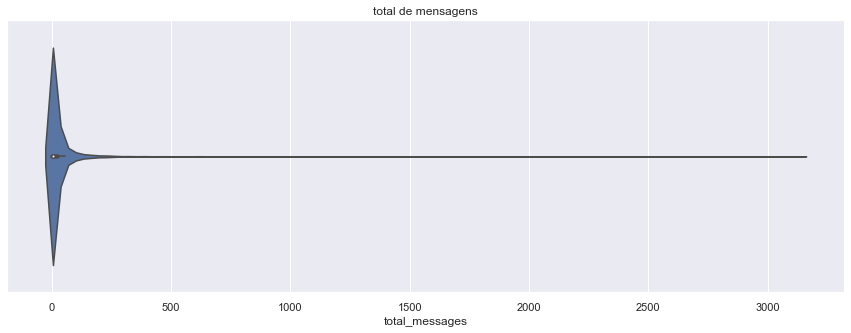

In [149]:
# active users
values = df_users['total_messages']
plt.figure(figsize=(15,5))
plt.title('total de mensagens')
ax = sns.violinplot(x=values,color ='C0')
print(values.describe())
print('outliers',outlier(values))

# Defining malicious users using the distributions of variables
We consider only the active users for that

In [158]:
# only active users
# this definition is very important! We have to choose carefully!!!

df_active_users = df_users[df_users['total_messages'] >= 50]

count    688.000000
mean       0.014138
std        0.031949
min        0.000000
25%        0.000000
50%        0.000000
75%        0.016949
max        0.301587
Name: misinformation_ratio, dtype: float64
outliers 0.0423728813559322


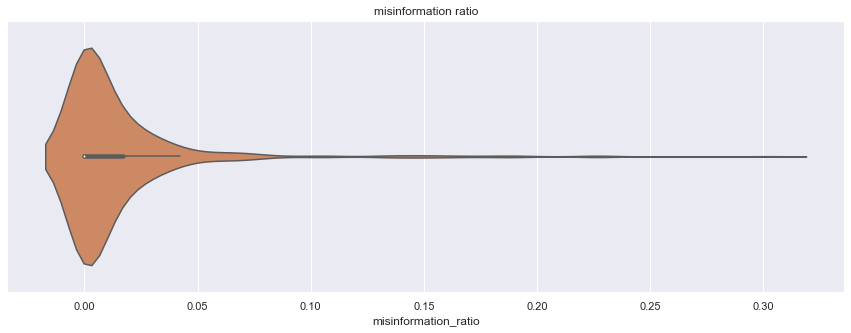

In [159]:
# source

values = df_active_users['misinformation_ratio']
plt.figure(figsize=(15,5))
plt.title('misinformation ratio')
ax = sns.violinplot(x=values,color ='C1')
print(values.describe())
print('outliers',outlier(values))


misinformation_ratio_threshold = outlier(values)


count    688.000000
mean       1.882267
std        4.737270
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       49.000000
Name: misinformations, dtype: float64
outliers 5.0


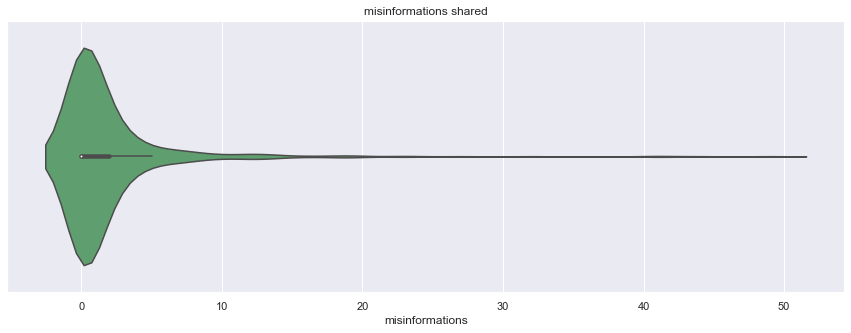

In [160]:
# absolute value

values = df_active_users['misinformations']
plt.figure(figsize=(15,5))
plt.title('misinformations shared')
ax = sns.violinplot(x=values, color = 'C2')
print(values.describe())
print('outliers',outlier(values))

misinformations_threshold = outlier(values)

count      688.000000
mean       339.481105
std        891.099853
min          0.000000
25%          0.000000
50%          0.000000
75%        306.000000
max      11398.000000
Name: misinformation_for_reached_user, dtype: float64
outliers 765.0


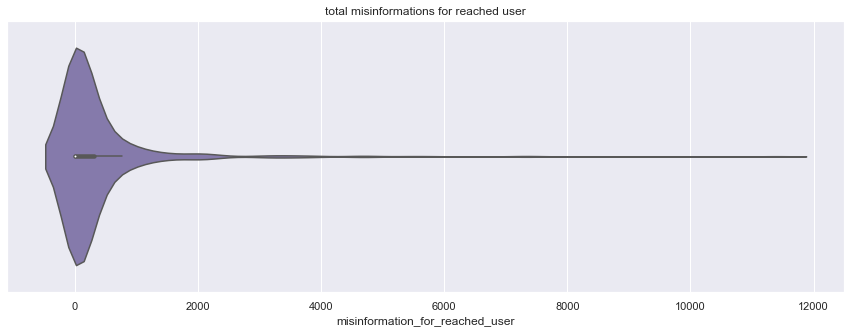

In [161]:
# relative to users value

values = df_active_users['misinformation_for_reached_user']
plt.figure(figsize=(15,5))
plt.title('total misinformations for reached user')
ax = sns.violinplot(x=values, color = 'C4')
print(values.describe())
print('outliers',outlier(values))

misinformation_for_reached_user_threshold = outlier(values)

In [162]:
# applying definitions
df_users['source_of_misinformation'] = [1 if x >= misinformation_ratio_threshold else 0 for x in df_users['misinformation_ratio']]
df_users['superspreader'] = [1 if x >= misinformation_for_reached_user_threshold else 0 for x in df_users['misinformation_for_reached_user']]
df_users['spreader'] = [1 if x >= misinformations_threshold else 0 for x in df_users['misinformations']]

df_users['malicious']  = ((df_users['source_of_misinformation'])  | (df_users['superspreader']) | (df_users['spreader']))
df_users.head()

,id,total_messages,viral_messages,texts,midia,urls,number_of_groups,reached_users,messages_for_reached_user,misinformations,misinformation_ratio,users_misinformed,misinformation_for_reached_user,messages,preprocessed_messages,preprocessed_stemmed_messages,source_of_misinformation,superspreader,spreader,malicious
0,-3818310068976662355,3134,22,3133,1,133,1,153,479502,0,0.000000,0,0,Ontem eu vi um vídeo de um travesti xingando a...,ontem vi video travesti xingando ser blasfemou...,ont vi vide travest xing ser blasfem jesu comi...,0,0,0,0
1,2839535797075678550,1330,51,1329,1,110,5,824,407516,8,0.006015,705,2166,"*Ordem em meio a caos, o sucesso das escolas m...","* ordem meio caos , sucesso escolas militares ...","* ord mei cao , sucess escol milit . * \n \n _...",0,1,1,1
2,-2072140886659020977,855,168,854,1,262,3,524,152557,23,0.026901,218,3277,Kkkk as urnas que são fraudadas kkkk essa desc...,kkk urnas sao fraudadas kkk desculpe ha ja deu...,kkk urn sao fraud kkk desculp ha ja deu ne ? ?...,0,1,1,1
3,-7379073963651272087,845,3,844,1,1,1,272,229840,0,0.000000,0,0,😂😂😂😂😂 👏🏻👏🏻👏🏻👏🏻👏🏻 Alguém tem o vídeo da parte d...,😂 😂 😂 😂 😂 👏 🏻 👏 🏻 👏 🏻 👏 🏻 👏 🏻 alguem video par...,😂 😂 😂 😂 😂 👏 🏻 👏 🏻 👏 🏻 👏 🏻 👏 🏻 algu vide part d...,0,0,0,0
4,3201344459315743060,831,2,830,1,21,1,272,226032,0,0.000000,0,0,Boa noite caros amigos! 🤝🏼 Seja bem vindo ao *...,boa noite caros amigos ! 🤝 🏼 bem vindo * endir...,boa noit car amig ! 🤝 🏼 bem vind * endireit ma...,0,0,0,0


In [169]:
df_users.to_csv('data/2018/user_features.csv',index = False)

# Hypotesis
Most of misinformation is spread by malicious / untrustful users

In [163]:
malicious = set(df_users[df_users['malicious']==1]['id'])

# misinformation
total_mis = len(df[df['misinformation']==1])
print('total misinformation: ',total_mis)

def messages_by_superspreaders(user,superspreaders):
    if user in superspreaders:
        return True
    else:
        return False

superspreader_mask = []
for u in df['id']:
    superspreader_mask.append(messages_by_superspreaders(u,malicious))
    
df_superspreaders = df[superspreader_mask]
df_superspreaders = df_superspreaders[df_superspreaders['misinformation']==1]

print('total malicious users',len(df_superspreaders))
print('proportion of malicious users {a:.2f}'.format(a = len(superspreaders)/len(df_users)))
print('proportion of misinformation sent by malicious users: {a:.2f}'.format(a = len(df_superspreaders)/total_mis))

total misinformation:  2122
total malicious users 1695
proportion of malicious users 0.01
proportion of misinformation sent by malicious users: 0.80


In [164]:
sofn = set(df_users[df_users['source_of_misinformation']==1]['id'])
spreader = set(df_users[df_users['spreader']==1]['id'])
superspreader = set(df_users[df_users['superspreader']==1]['id'])

print('sources of misinformation', len(sofn))
print('spreader', len(spreader))
print('superspreader', len(superspreader))
print()
print('intersection sofn & spreader', len(sofn.intersection(spreader)))
print('intersection sofn & superspreader', len(sofn.intersection(superspreader)))
print('intersection superspreader & spreader', len(superspreader.intersection(spreader)))

print('intersection sofn & superspreader & spreader', len(superspreader.intersection(sofn.intersection(spreader))))


sources of misinformation 458
spreader 90
superspreader 102

intersection sofn & spreader 58
intersection sofn & superspreader 55
intersection superspreader & spreader 68
intersection sofn & superspreader & spreader 40


# Experiment design


### Models
* Classic machine learning
    * Logistic regression with SGD
    * Random forest
    * MLP or SVM
* Deep Learning
    * Char-level CNN

### Features
* User features: 'total_messages', 'viral_messages', 'texts', 'midia', 'urls', 'number_of_groups', 'reached_users', 'messages_for_reached_user'
* Text features: 
    * TF-IDF (2,2), 
    * Topics (LDA), 
    * Word2Vec
* Graph features?
    * Node2Vec

### Metrics
* Accuracy, precision, recall, F1, AUC

## Scenarios
* A: ML models with user features
* B: ML models with user features + text
* C: DL with chars
* D: DL + user features

# User representation

In [165]:
df_active_users.columns

Index(['id', 'total_messages', 'viral_messages', 'texts', 'midia', 'urls',
       'number_of_groups', 'reached_users', 'messages_for_reached_user',
       'misinformations', 'misinformation_ratio', 'users_misinformed',
       'misinformation_for_reached_user', 'messages', 'preprocessed_messages',
       'preprocessed_stemmed_messages', 'source_of_misinformation',
       'superspreader', 'spreader', 'malicious'],
      dtype='object')

In [168]:
# user data

user_features = ['total_messages', 'viral_messages', 'texts', 'midia', 'urls',
                 'number_of_groups', 'reached_users', 'messages_for_reached_user']
X_user = df_active_users[user_features]
y = df_active_users['malicious']

### Feature selection

In [183]:
X_user

,total_messages,viral_messages,texts,midia,urls,number_of_groups,reached_users,messages_for_reached_user
0,3134,22,3133,1,133,1,153,479502
1,1330,51,1329,1,110,5,824,407516
2,855,168,854,1,262,3,524,152557
3,845,3,844,1,1,1,272,229840
4,831,2,830,1,21,1,272,226032
...,...,...,...,...,...,...,...,...
683,50,0,49,1,1,1,188,9400
684,50,2,49,1,7,1,302,15100
685,50,9,49,1,0,1,309,15450
686,50,2,49,1,2,1,302,15100


In [182]:
# univariate
X_user.std()

total_messages                 174.880198
viral_messages                  19.968765
texts                          174.878948
midia                            0.065938
urls                            38.195297
number_of_groups                 0.943569
reached_users                  163.034248
messages_for_reached_user    38135.876395
dtype: float64

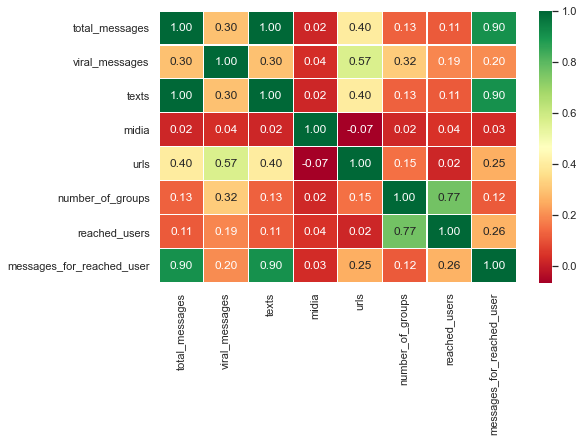

In [179]:
#get correlations of each features in dataset
corrmat = X_user.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,5))
#plot heat map
# sns.heatmap(df_similar, annot=True, fmt='.2f', linewidths=.1)
g=sns.heatmap(X_user[top_corr_features].corr(),annot=True, fmt='.2f', linewidths=.1,cmap="RdYlGn")

In [ ]:
# feature importance

import pandas as pd
import numpy as np
data = pd.read_csv("D://Blogs//train.csv")
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Train-Test split

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

# Feature engineering
* Representation
* Feature selection
* Dimensionality reduction
* Normalization

# Data balancing

# Hyperparameter tuning

# Test evaluation